# FE 621A: HW #2
Name: Siddharth Iyer
Date: 2/27/2022

Pledge: I pledge my honor that I have abided by the Stevens Honor System. 
<hr/>

### Import Packages

In [386]:
import numpy as np
import pandas as pd
from scipy.stats import norm

import matplotlib.pyplot as plt
import plotly.express as px

## Problem 1

**(a) Write code that takes $S_0$, K, $\sigma$, r, T and N as inputs and computes the prices of options using an additive N-step binomial tree. Your code should be able to handle European and American call and put options. For the additive tree, use the parametrization described in class and also given in Eq. (2.19) in Clewlow/Strickland.**

In [387]:
# Parameters
S0 = 100
K = 90
sig = .2
r = .06
T = .5
N = 10

Generate Additive Price Tree & Compute Option Price

In [388]:
def generate_additive_price_tree(S0, sig, r, T, N):
    dt = T/N
    v = (r - np.power(sig, 2)/2)
    dx = np.sqrt(np.power(v, 2) * np.power(dt, 2) + np.power(sig, 2)*dt)
    q = 1/2 + 1/2*v*dt/dx

    prices_array = [np.array([np.log(S0)])]

    for i in range(N):
        prev_prices = prices_array[i]
        down_arr = prev_prices - dx
        next_prices = np.append(down_arr, prev_prices[-1]+dx)
        prices_array.append(next_prices)

    return [np.exp(st) for st in prices_array]

def compute_additive_option_price(S0, K, sig, r, T, N, op_type):
    prices_array = generate_additive_price_tree(S0, sig, r, T, N)
    v = (r - np.power(sig, 2)/2)
    dt = T/N
    dx = np.sqrt(np.power(v, 2) * np.power(dt, 2) + np.power(sig, 2)*dt)
    disc = np.exp(-r*dt)
    q = 1/2 + 1/2*v*dt/dx

    # European Option
    if op_type == "ec" or op_type == "ep":
        S = prices_array[-1]       # good news, for European you only need the last day's prices
        V = 0

        # value of option at terminal time
        if op_type == "ec":
            V = np.maximum(S - K, np.zeros(N+1))
        elif op_type == "ep":
            V = np.maximum(K - S, np.zeros(N+1))

        # take 2 at a time and get weighted-discounted value
        for i in np.arange(N,0,-1):
            V = disc * ( q* V[1:i+1] + (1-q) * V[0:i])
        # final result is option price
        return V[0]

    # American Option
    elif op_type == "ac" or op_type == "ap":
        # terminal value of stock
        S = prices_array[N]

        V = 0
        # value of payoff at terminal time
        if op_type == "ac":
            V = np.maximum(0, S - K)
        elif op_type == "ap":
            V = np.maximum(0, K - S)

        # backtrack through options tree
        for i in np.arange(N-1, -1, -1):
            # recalculate prices at current level
            S = prices_array[i]

            V[:i+1] = disc * ( q*V[1:i+2] + (1-q)*V[0:i+1] )                
            V = V[:-1]

            if op_type == 'ap':
                V = np.maximum(V, K - S)
            elif op_type == "ac":
                V = np.maximum(V, S - K)
        return V[0]

**(b) Analyze the convergence of the binomial tree prices to the Black-Scholes options prices as the number of steps gets larger. Specifically, for the four types of options, plot the difference between the Black-Scholes price and the N-step binomial tree price for different values of N. **

The convergence follows a damped ossilation...when K=100, there is no increasing and decreasing of error. For some reason it seem that as more steps are added, the error alternates between under and over shooting the target value. This could be leveraged by take the average of N and N+1 instead of trying higher N. The beginning of the convergence has almost no discernable pattern and is erratic.

In [389]:
def black_scholes_d1_d2(S0, r, sig, tau, K):
    sigtau = sig*np.sqrt(tau)
    d1 = 1/(sigtau) * (np.log(S0/K) + (r + np.power(sig, 2)/2) * tau)
    d2 = d1 - sigtau
    return (d1,d2)

def black_scholes_options_pricing(S0, r, sig, tau, K, typ):
    """
    Returns the price of an option with user specified inputs:

        S0  (float) - initial / current price of the underlying stock \n
        r   (float) - risk free interest rate; annualized YTM of T-Bills at any maturity user wants \n
        sig (float) - volatility of underlying stock, must be in range(0,1) \n
        tau (float) - time to maturity, i.e. T-t \n
        K   (float) - strike price of option \n
        typ (str)   - specifies the type of options as either "call" or "put" \n
    
    Please don't be annyoing...only input values that make sense. \n
    Ref: https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model
    """
    d1, d2 = black_scholes_d1_d2(S0, r, sig, tau, K)

    if typ == "call":
        return norm.cdf(d1)*S0 - norm.cdf(d2)*K*np.exp(-r*tau)
    elif typ == "put":
        return norm.cdf(-d2)*K*np.exp(-r*tau) - norm.cdf(-d1)*S0
    else:
        return "Not supported"

In [390]:
true_price_ec = black_scholes_options_pricing(S0, r, sig, T, K, "call")
true_price_ep = black_scholes_options_pricing(S0, r, sig, T, K, "put")
true_price_ac = compute_additive_option_price(S0, K, sig, r, T, 5000, "ac")
true_price_ap = compute_additive_option_price(S0, K, sig, r, T, 5000, "ap")

upper_lim_N = 100
additive_option_error_wrt_N_ac = [(compute_additive_option_price(S0, K, sig, r, T, i, op_type="ac") - true_price_ac) for i in range(1, upper_lim_N)]
additive_option_error_wrt_N_ap = [(compute_additive_option_price(S0, K, sig, r, T, i, op_type="ap") - true_price_ap) for i in range(1, upper_lim_N)]
additive_option_error_wrt_N_ec = [(compute_additive_option_price(S0, K, sig, r, T, i, op_type="ec") - true_price_ec) for i in range(1, upper_lim_N)]
additive_option_error_wrt_N_ep = [(compute_additive_option_price(S0, K, sig, r, T, i, op_type="ep") - true_price_ep) for i in range(1, upper_lim_N)]

Generate Plots of Error Convergence for 4 option types

Text(0.5, 1.0, 'Error function for Additive BTree Option Pricing to Black Scholes (European Call)')

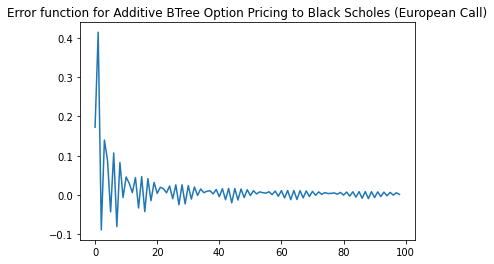

In [391]:
plt.plot(additive_option_error_wrt_N_ec)
plt.title("Error function for Additive BTree Option Pricing to Black Scholes (European Call)")

Text(0.5, 1.0, 'Error function for Additive BTree Option Pricing to Black Scholes (European Put)')

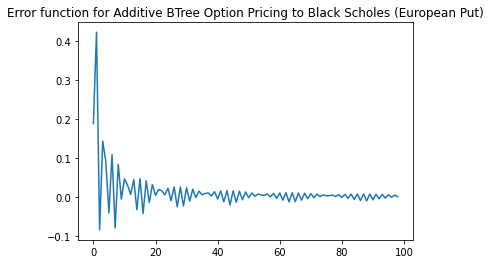

In [392]:
plt.clf()
plt.plot(additive_option_error_wrt_N_ep)
plt.title("Error function for Additive BTree Option Pricing to Black Scholes (European Put)")

Text(0.5, 1.0, 'Error function for Additive BTree Option Pricing to Black Scholes (American Call)')

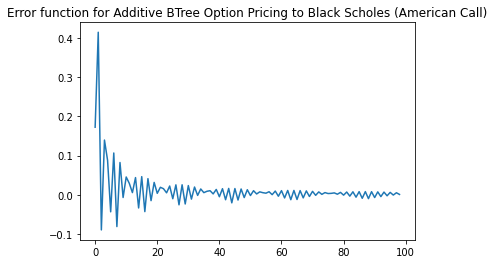

In [393]:
plt.clf()
plt.plot(additive_option_error_wrt_N_ac)
plt.title("Error function for Additive BTree Option Pricing to Black Scholes (American Call)")

Text(0.5, 1.0, 'Error function for Additive BTree Option Pricing to Black Scholes (American Put)')

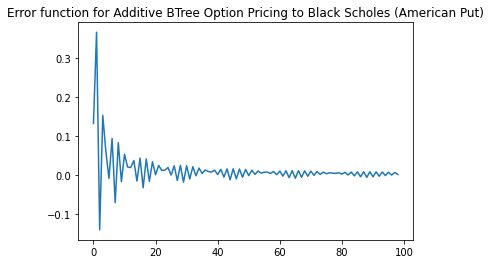

In [394]:
plt.clf()
plt.plot(additive_option_error_wrt_N_ap)
plt.title("Error function for Additive BTree Option Pricing to Black Scholes (American Put)")

### Problem 2

**(a) Write code that takes S0, K, H, σ, r, T and N as inputs and uses an N-step (multiplicative) binomial tree to price a European Up-and-Out call option with barrier H.**

In [395]:
# Parameters
S0 = 10
H = 11
K = 10
sig = .2
r = .01
T = .3
N = 10000

Compute the Multiplicative Binomial Tree Stock Prices, Up-and-out call price, also included a vanilla option pricing tool

In [396]:
def generate_mult_price_tree(S0, sig, T, N):
    dt = T/N
    u = np.exp(sig*np.sqrt(dt))
    d = 1/u

    prices_array = [np.array([S0])]
    for i in range(1, N+1):
        prices_array.append(S0 * (d ** np.arange(i, -1, -1) * (u ** np.arange(0, i+1, 1))))
    
    return prices_array

def compute_mult_up_out_barrier_option_price(S0, K, H, sig, r, T, N, op_type):
    prices_array = generate_mult_price_tree(S0, sig, T, N)
    dt = T/N
    u = np.exp(sig*np.sqrt(dt))
    d = 1/u
    disc = np.exp(-r*dt)
    q = (np.exp(r*dt) - d)/(u-d)

    if op_type == "c":
        V = np.maximum(prices_array[-1] - K, np.zeros(N+1))
    elif op_type == "p":
        V = np.maximum(K - prices_array[-1], np.zeros(N+1))

    V[prices_array[-1] > H] = 0

    for i in np.arange(N, 0, -1):
        S = prices_array[i-1]
        V = disc * ( q* V[1:i+1] + (1-q) * V[0:i])
        V[S>H] = 0

    # final result is option price
    return V[0]

def compute_multiplicative_option_price(S0, K, sig, r, T, N, op_type):
    prices_array = generate_mult_price_tree(S0, sig, T, N)
    dt = T/N
    u = np.exp(sig*np.sqrt(dt))
    d = 1/u
    disc = np.exp(-r*dt)
    q = (np.exp(r*dt) - d)/(u-d)

    # European Option
    if op_type == "ec" or op_type == "ep":
        S = prices_array[-1]       # good news, for European you only need the last day's prices
        V = 0

        # value of option at terminal time
        if op_type == "ec":
            V = np.maximum(S - K, np.zeros(N+1))
        elif op_type == "ep":
            V = np.maximum(K - S, np.zeros(N+1))

        # take 2 at a time and get weighted-discounted value
        for i in np.arange(N,0,-1):
            V = disc * ( q* V[1:i+1] + (1-q) * V[0:i])
        # final result is option price
        return V[0]

    # American Option
    elif op_type == "ac" or op_type == "ap":
        # terminal value of stock
        S = prices_array[N]

        V = 0
        # value of payoff at terminal time
        if op_type == "ac":
            V = np.maximum(0, S - K)
        elif op_type == "ap":
            V = np.maximum(0, K - S)

        # backtrack through options tree
        for i in np.arange(N-1, -1, -1):
            # recalculate prices at current level
            S = prices_array[i]

            V[:i+1] = disc * ( q*V[1:i+2] + (1-q)*V[0:i+1] )                
            V = V[:-1]

            if op_type == 'ap':
                V = np.maximum(V, K - S)
            elif op_type == "ac":
                V = np.maximum(V, S - K)
        return V[0]

In [397]:
compute_mult_up_out_barrier_option_price(S0, K, H, sig, r, T, N, "c")

0.054989693964286844

**(b) Analyze the convergence of the tree-price to the exact price in the same way as in Problem 1(b).**

The convergence of this Up-and-out barrier option has an almost step function like behaior. There are spikes and gradual decreases in error bound. The frequency of the spikes in error are getting longer for some reason. 

In [398]:
def up_out_analytical_soln(S0, K, H, sig, r, T):
    v = r - np.power(sig, 2)/2
    price = black_scholes_options_pricing(S0, r, sig, T, K, "call") - black_scholes_options_pricing(S0, r, sig, T, H, "call") - (H-K)*np.exp(-r*T)*norm.cdf( (np.log(S0/H)+v*T)/(sig*np.sqrt(T)) )
    - np.power(H/S0, 2*v/np.power(sig, 2)) * (black_scholes_options_pricing(np.power(H,2)/S0, r, sig, T, K, "call") - black_scholes_options_pricing(np.power(H,2)/S0, r, sig, T, H, "call")- (H-K)*np.exp(-r*T)*norm.cdf((np.log(H/S0)+v*T)/(sig*np.sqrt(T)) ))

    return price

In [399]:
true_price_barrier_ec = 0.05
true_price_barrier_ep = .4
upper_lim_N = 300
mult_barrier_error_wrt_N_ec = [(compute_mult_up_out_barrier_option_price(S0, K, H, sig, r, T, i, "c") - true_price_barrier_ec) for i in range(1, upper_lim_N)]

Text(0.5, 1.0, 'Error convergence of Up-and-Out Barrier Call Option')

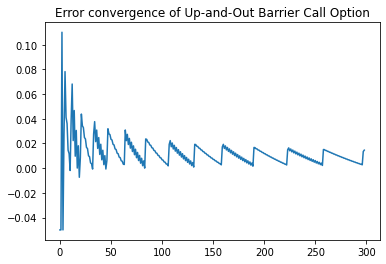

In [400]:
plt.plot(mult_barrier_error_wrt_N_ec)
plt.title("Error convergence of Up-and-Out Barrier Call Option")
# up_out_analytical_soln(S0, K, H, sig, r, T)

**(c) Provide a numerical recipe for using a binomial tree to price an American Up-and-In call option. Clearly explain the key steps in your backward dynamic programming procedure. In this problem you do not need to write any code - just provide a description of your computational procedure.**

For Up-and-out call options, at each level, if the stock price is greater than the barrier, you simply have to set all those option values (in the tree at time t) to 0. This won't work for this problem because being below H isn't a guarentee that at some point in the past. 

We need to find the first level n such that the max point reached is > H. 

$$u^n s_0 >= H$$
$$int(n) >= ln_u(H/S_0)$$

This is the first level that crosses barrier H. Every branch from this point forward must be included in our American pricing methodology. All others at the last level (N) should be set to 0. In effect, at the terminal layer N, only the top $N-n+1$ should be evaluated. Everything else will be 0. Then we simply continue with pricing as coded above. 





### Problem 3

**(a) Write a function that takes p as input and uses a (multiplicative) binomial tree to compute the value V0(p) of an installment call option. Use parameters S0 = 100, σ = 0.20, r = 0.04, K = 90, T = 1, and n = 4.**

In [359]:
# Parameters
S0 = 100
K = 90
sig = .2
p = 1
r = .04
T = 1
N = 4

In [360]:
def compute_mult_installment_option_price(S0, K, sig, r, T, N, p, op_type):
    prices_array = generate_mult_price_tree(S0, sig, T, N)
    dt = T/N
    u = np.exp(sig*np.sqrt(dt))
    d = 1/u
    disc = np.exp(-r*dt)
    q = (np.exp(r*dt) - d)/(u-d)

    if op_type == "c":
        V = np.maximum(prices_array[-1] - K, np.zeros(N+1))
    elif op_type == "p":
        V = np.maximum(K - prices_array[-1], np.zeros(N+1))

    for i in np.arange(N, 0, -1):
        V = disc * ( q* np.maximum(V[1:i+1]-p, 0) + (1-q) * np.maximum(V[0:i]-p, 0))

    return V[0]

In [361]:
print("Discounted value of installment option: ", compute_mult_installment_option_price(S0, K, sig, r, T, N, p, "c"))

Discounted value of installment option:  12.87371617497259


**(b) The arbitrage-free premium of an installment option is the value of p such that V0(p) = p. Plot V0(p) as a function of p and find the arbitrage-free value of p.**

Looks roughly $4.21 for arbitrage free price of the installment option w/parameters above.

Installment Value:  4.210802914460784


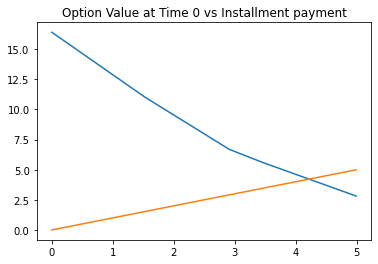

In [362]:
x = np.arange(0, 5, .01)
y = np.array([compute_mult_installment_option_price(S0, K, sig, r, T, N, i, "c") for i in x])

plt.plot(x, y)
plt.plot(x, x)
plt.title("Option Value at Time 0 vs Installment payment")
p = y[x>y][0]
print("Installment Value: ", p)

**(c) Price a standard European call option using the binomial tree and the same parameters as in part (a). How does its price compare to the sum of the discounted installment payments  Report both values and explain your findings.**

The European call option price and discounted installment payment price is approximately the same! This makes sense because they are both European options with the same payoff. And although the contract can be terminated early, it cannot be executed early. There is no advantage to be gained from it since risk neturality guarentees the expected value of holding will never be negative outside of jumps.

This implementation has an issue; the number of steps in the tree must always match the number of installment payments. This prevents my from getting finer estimates for a given number of payemnts. 

In [363]:
print("Black Scholes Price: ", black_scholes_options_pricing(S0, r, sig, T, K, "call"))
print("Discounted Installments: ", np.sum(p*np.exp(-r*np.arange(0, N, 1)*T/N)))


Black Scholes Price:  16.060428014488096
Discounted Installments:  16.59348595117538
